In [1]:
import numpy as np
import pandas as pd
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import torchvision.transforms.functional as F
from torchvision import models

from torch.utils.data import random_split
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm

from sklearn.metrics import roc_auc_score

In [2]:
data_dir = "MRNet-v1.0"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "valid")
print(train_dir)
print(val_dir)

def create_df(mode):
    sagittal = os.path.join(data_dir, f"{mode}/sagittal")
    axial = os.path.join(data_dir, f"{mode}/axial")
    coronal = os.path.join(data_dir, f"{mode}/coronal")
    axis = [sagittal, axial, coronal]
    labels = ['acl','meniscus','abnormal']
    paths = [os.path.join(data_dir, f"{mode}-{l}.csv") for l in labels]

    l1 = pd.read_csv(paths[0], header=None, names=['case', labels[0]], dtype={'case': str, labels[0]: np.int64})
    l2 = pd.read_csv(paths[1], header=None, names=['case', labels[1]], dtype={'case': str, labels[1]: np.int64})
    l3 = pd.read_csv( paths[2], header=None, names=['case', labels[2]], dtype={'case': str, labels[2]: np.int64})
    final_df = pd.DataFrame({'case': l1['case'], labels[0]: l1[labels[0]], labels[1]: l2[labels[1]], labels[2]: l3[labels[2]],})

    return final_df

MRNet-v1.0\train
MRNet-v1.0\valid


In [3]:
train_df = create_df('train')
val_df = create_df('valid')

train_df['axial'] = train_df['case'].apply(lambda x: os.path.join(train_dir, 'axial', f"{x}.npy"))
train_df['coronal'] = train_df['case'].apply(lambda x: os.path.join(train_dir, 'coronal', f"{x}.npy"))
train_df['sagittal'] = train_df['case'].apply(lambda x: os.path.join(train_dir, 'sagittal', f"{x}.npy"))

val_df['axial'] = val_df['case'].apply(lambda x: os.path.join(val_dir, 'axial', f"{x}.npy"))
val_df['coronal'] = val_df['case'].apply(lambda x: os.path.join(val_dir, 'coronal', f"{x}.npy"))
val_df['sagittal'] = val_df['case'].apply(lambda x: os.path.join(val_dir, 'sagittal', f"{x}.npy"))

test_df = train_df.sample(n=130, random_state=42)
train_df = train_df.drop(test_df.index)

print(f"train_df length: {len(train_df)}")
print(f"val_df length: {len(val_df)}")
print(f"test_df length: {len(test_df)}")

train_df length: 1000
val_df length: 120
test_df length: 130


In [14]:
train_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomPerspective(distortion_scale=0.1, p=0.5),
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
    #transforms.RandomAutocontrast(p=0.5),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5], std=[0.5])
    #transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5], std=[0.5])
    #transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5], std=[0.5])
    #transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])



class KneeDataset(Dataset):
    def __init__(self, df, plane, transform=None, num_slices=8):
        self.df = df
        self.plane = plane
        self.transform = transform
        self.num_slices = num_slices
        self.labels = ["acl", "meniscus", "abnormal"]
        self.samples = self._flatten_dataset()


    def _flatten_dataset(self):
        samples = []
        for _, row in self.df.iterrows():
            # Load the .npy file for the specified plane
            image_path = row[self.plane]
            volume = np.load(image_path)
            
            # Truncate to the most centered num_slices slices
            start_idx = (volume.shape[0] - self.num_slices) // 2
            end_idx = start_idx + self.num_slices
            truncated_volume = volume[start_idx:end_idx]
            
            # Append each slice and its labels to the samples list
            for slice_idx in range(truncated_volume.shape[0]):
                samples.append((truncated_volume[slice_idx], row[self.labels].values))
    
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        row = self.samples[idx]
        slice_data, labels = row  # Unpack slice data and labels
        
        image = Image.fromarray(slice_data)

        if self.transform:
            image = self.transform(image)

        labels = torch.from_numpy(labels.astype(np.float32))
        return image, labels

axial_train_ds = KneeDataset(train_df, plane="axial", transform=train_transforms)
coronal_train_ds = KneeDataset(train_df, plane="coronal", transform=train_transforms)
sagittal_train_ds = KneeDataset(train_df, plane="sagittal", transform=train_transforms)

axial_val_ds = KneeDataset(val_df, plane="axial", transform=val_transforms)
coronal_val_ds = KneeDataset(val_df, plane="coronal", transform=val_transforms)
sagittal_val_ds = KneeDataset(val_df, plane="sagittal", transform=val_transforms)

axial_test_ds = KneeDataset(test_df, plane="axial", transform=test_transforms)
coronal_test_ds = KneeDataset(test_df, plane="coronal", transform=test_transforms)
sagittal_test_ds = KneeDataset(test_df, plane="sagittal", transform=test_transforms)

print(f"axial_train_dataset length: {len(axial_train_ds)}")
print(f"coronal_train_dataset length: {len(coronal_train_ds)}")
print(f"sagittal_train_dataset length: {len(sagittal_train_ds)}", "\n")

print(f"axial_val_dataset length: {len(axial_val_ds)}")
print(f"coronal_val_dataset length: {len(coronal_val_ds)}")
print(f"sagittal_val_dataset length: {len(sagittal_val_ds)}", "\n")

print(f"axial_test_dataset length: {len(axial_test_ds)}")
print(f"coronal_test_dataset length: {len(coronal_test_ds)}")
print(f"sagittal_test_dataset length: {len(sagittal_test_ds)}", "\n")

# ~ 2 min

axial_train_dataset length: 8000
coronal_train_dataset length: 8000
sagittal_train_dataset length: 8000 

axial_val_dataset length: 960
coronal_val_dataset length: 960
sagittal_val_dataset length: 960 

axial_test_dataset length: 1040
coronal_test_dataset length: 1040
sagittal_test_dataset length: 1040 



In [15]:
def check_flattening(ds1, ds2, ds3):
    for index in range(len(ds1)):

        image, labels = ds1[index]
        
        if not torch.equal(labels, ds2[index][1]) or not torch.equal(labels, ds3[index][1]):
            print("Labels mismatch at index:", index) 
            break

#check_flattening(axial_train_ds, coronal_train_ds, sagittal_train_ds)
#check_flattening(axial_val_ds, coronal_val_ds, sagittal_val_ds)
#check_flattening(axial_test_ds, coronal_test_ds, sagittal_test_ds)

In [16]:
train_ds = torch.utils.data.ConcatDataset([axial_train_ds, coronal_train_ds, sagittal_train_ds])
val_ds = torch.utils.data.ConcatDataset([axial_val_ds, coronal_val_ds, sagittal_val_ds])
test_ds = torch.utils.data.ConcatDataset([axial_test_ds, coronal_test_ds, sagittal_test_ds])

print(f"train_dataset length: {len(train_ds)}")
print(f"val_dataset length: {len(val_ds)}")
print(f"test_dataset length: {len(test_ds)}")

train_dataset length: 24000
val_dataset length: 2880
test_dataset length: 3120


Labels: tensor([0., 0., 1.])


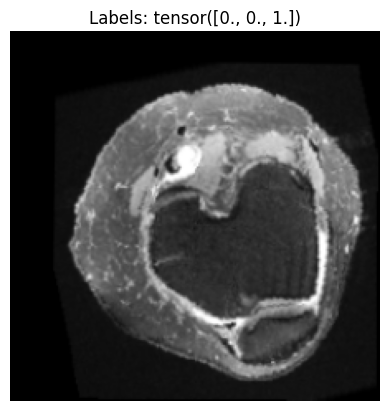

In [17]:
def visualize_image(dataset, idx):
    image, labels = dataset[idx]
    print(f"Labels: {labels}")

    image = F.to_pil_image(image)
    plt.imshow(image, cmap="gray")
    plt.title(f"Labels: {labels}")
    plt.axis("off")
    plt.show()

visualize_image(train_ds, 1)

In [18]:
batch_size = 32

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 3

model = models.efficientnet_b0(weights='IMAGENET1K_V1')

# Modify the final FC layer
model.classifier[1] = nn.Sequential(
    nn.Linear(model.classifier[1].in_features, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes) 
)

# Freeze all layers except the FC layers and last 3 conv blocks
for param in model.parameters():
    param.requires_grad = False

for param in model.features[-1].parameters():
    param.requires_grad = True

for param in model.features[-2].parameters():
    param.requires_grad = True

for param in model.features[-3].parameters():
    param.requires_grad = True

for param in model.classifier[1].parameters():
    param.requires_grad = True
    
model = model.to(device)


# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


train_losses = []
val_losses = []
train_roc_aucs = []
val_roc_aucs = []

# Epoch training Loop with ROC AUC Calculation
def train_one_epoch_with_auc(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    all_preds, all_labels = [], []

    for images, labels in tqdm(dataloader, desc="Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        all_preds.append(outputs.sigmoid().detach().cpu())
        all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    roc_auc = roc_auc_score(all_labels.numpy(), all_preds.numpy(), average="weighted")

    return running_loss / len(dataloader), roc_auc

# Validation Loop
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            all_preds.append(outputs.sigmoid().cpu())
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    roc_auc = roc_auc_score(all_labels.numpy(), all_preds.numpy(), average="weighted")

    return running_loss / len(dataloader), roc_auc



# Training loop
num_epochs = 10
best_val_auc = 0.0

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    
    # Training step
    train_loss, train_auc = train_one_epoch_with_auc(model, train_dl, optimizer, criterion, device)
    train_losses.append(train_loss)  # Save training loss
    train_roc_aucs.append(train_auc)  # Save training roc auc

    # Validation step
    val_loss, val_auc = validate(model, val_dl, criterion, device)
    val_losses.append(val_loss)  # Save validation loss
    val_roc_aucs.append(val_auc)  # Save validation roc auc

    print(f"Train Loss: {train_loss:.4f}, Train AUC: {train_auc:.4f}, Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}")

    # Save the best model
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save(model.state_dict(), "best_model.pth")
        print("Saved Best Model")

# Load the best model
model.load_state_dict(torch.load("best_model.pth", weights_only=True))

# ~30 min @ GTX1080

Epoch 1/10


Validation: 100%|██████████| 90/90 [00:07<00:00, 12.76it/s]


Train Loss: 0.4657, Train AUC: 0.7666, Val Loss: 0.5873, Val AUC: 0.7894
Saved Best Model
Epoch 2/10


Validation: 100%|██████████| 90/90 [00:06<00:00, 13.03it/s]


Train Loss: 0.4273, Train AUC: 0.8180, Val Loss: 0.5494, Val AUC: 0.8077
Saved Best Model
Epoch 3/10


Validation: 100%|██████████| 90/90 [00:06<00:00, 13.30it/s]


Train Loss: 0.4085, Train AUC: 0.8377, Val Loss: 0.5297, Val AUC: 0.8358
Saved Best Model
Epoch 4/10


Validation: 100%|██████████| 90/90 [00:06<00:00, 13.77it/s]


Train Loss: 0.3976, Train AUC: 0.8474, Val Loss: 0.5515, Val AUC: 0.8383
Saved Best Model
Epoch 5/10


Validation: 100%|██████████| 90/90 [00:06<00:00, 13.70it/s]


Train Loss: 0.3875, Train AUC: 0.8565, Val Loss: 0.5455, Val AUC: 0.8334
Epoch 6/10


Validation: 100%|██████████| 90/90 [00:06<00:00, 13.55it/s]


Train Loss: 0.3799, Train AUC: 0.8625, Val Loss: 0.4948, Val AUC: 0.8494
Saved Best Model
Epoch 7/10


Validation: 100%|██████████| 90/90 [00:06<00:00, 13.54it/s]


Train Loss: 0.3689, Train AUC: 0.8713, Val Loss: 0.6163, Val AUC: 0.8256
Epoch 8/10


Validation: 100%|██████████| 90/90 [00:06<00:00, 13.45it/s]


Train Loss: 0.3598, Train AUC: 0.8785, Val Loss: 0.5276, Val AUC: 0.8354
Epoch 9/10


Validation: 100%|██████████| 90/90 [00:06<00:00, 13.51it/s]


Train Loss: 0.3529, Train AUC: 0.8841, Val Loss: 0.5348, Val AUC: 0.8441
Epoch 10/10


Validation: 100%|██████████| 90/90 [00:06<00:00, 13.36it/s]


Train Loss: 0.3417, Train AUC: 0.8914, Val Loss: 0.5639, Val AUC: 0.8324


<All keys matched successfully>

In [27]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in tqdm(test_dl, desc="Testing"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        all_preds.append(outputs.sigmoid().cpu())
        all_labels.append(labels.cpu())

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

test_roc_auc = roc_auc_score(all_labels.numpy(), all_preds.numpy(), average="macro")
print(f"Test ROC AUC: {test_roc_auc:.4f}")

Testing: 100%|██████████| 98/98 [00:07<00:00, 12.62it/s]

Test ROC AUC: 0.8146


In [35]:
# print classification report
# Function to encode multi-labels into string combinations
def encode_combinations(labels):
    labels = labels.astype(int)  # Ensure integer format
    return ["".join(map(str, label)) for label in labels]

# Function to map label combinations to descriptive names
def map_combinations_to_names(combinations):
    mapping = {
        "000": "no issues",
        "100": "meniscus",
        "010": "acl",
        "001": "abnormalities",
        "110": "meniscus, acl",
        "101": "meniscus, abnormalities",
        "011": "acl, abnormalities",
        "111": "meniscus, acl, abnormalities",
    }
    return [mapping.get(combo, "unknown") for combo in combinations]

# Generate classification report for individual labels
def get_classification_report(all_labels, all_preds):
    # Binarize predictions
    all_preds_bin = (all_preds > 0.5).int()
    report = classification_report(
        all_labels.cpu().numpy(),
        all_preds_bin.cpu().numpy(),
        target_names=["acl", "meniscus", "abnormal"],
        zero_division=0,
    )
    print("Classification Report (Individual Labels):")
    print(report)

# Generate classification report for label combinations
def get_combination_classification_report_with_names(all_labels, all_preds):
    # Encode labels and predictions into combinations
    true_combinations = encode_combinations(all_labels.cpu().numpy())
    pred_combinations = encode_combinations((all_preds > 0.5).int().cpu().numpy())

    # Map combinations to descriptive names
    true_combination_names = map_combinations_to_names(true_combinations)
    pred_combination_names = map_combinations_to_names(pred_combinations)

    # Generate the classification report
    report = classification_report(
        true_combination_names,
        pred_combination_names,
        zero_division=0,
    )
    print("Classification Report (Label Combinations):")
    print(report)

# Assuming all_preds and all_labels are already concatenated tensors
get_classification_report(all_labels, all_preds)
get_combination_classification_report_with_names(all_labels, all_preds)

Classification Report (Individual Labels):
              precision    recall  f1-score   support

         acl       0.80      0.32      0.45       912
    meniscus       0.61      0.46      0.52      1032
    abnormal       0.85      0.89      0.87      2352

   micro avg       0.79      0.66      0.72      4296
   macro avg       0.76      0.55      0.61      4296
weighted avg       0.78      0.66      0.70      4296
 samples avg       0.62      0.52      0.54      4296

Classification Report (Label Combinations):
                              precision    recall  f1-score   support

               abnormalities       0.38      0.62      0.47       936
          acl, abnormalities       0.35      0.40      0.38       504
     meniscus, abnormalities       0.39      0.17      0.23       384
meniscus, acl, abnormalities       0.53      0.20      0.28       528
                   no issues       0.60      0.52      0.56       768

                    accuracy                           0

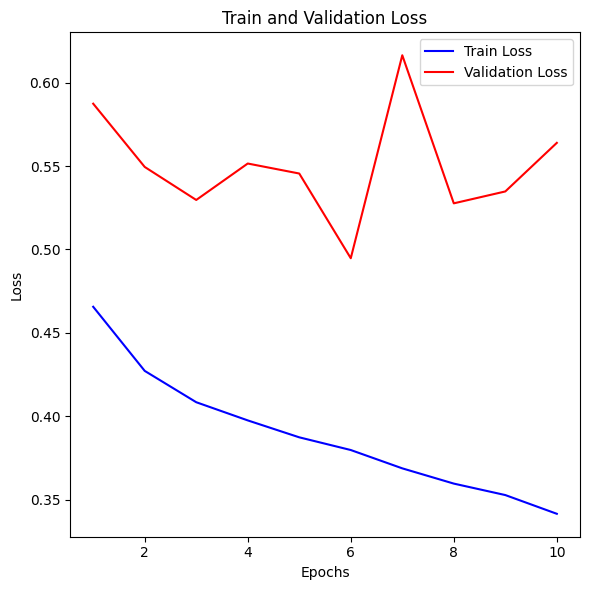

In [37]:
# Plot losses and ROC AUCs
plt.figure(figsize=(6, 6))

plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='b')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

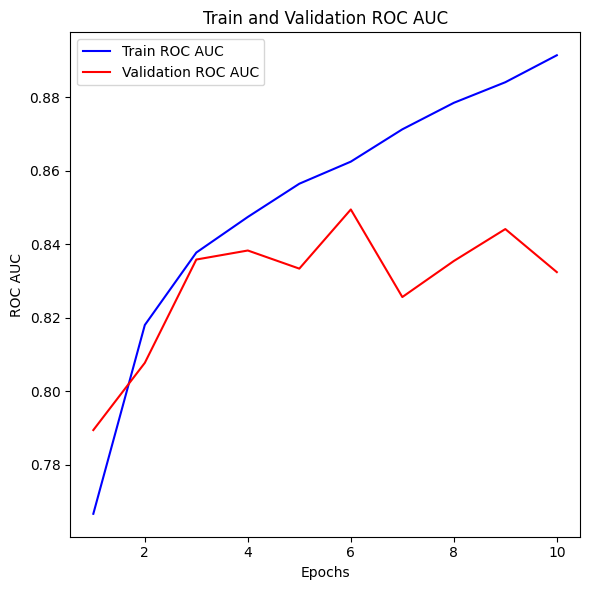

In [36]:
# Plot training and validation ROC AUC
plt.figure(figsize=(6, 6))

plt.plot(range(1, num_epochs + 1), train_roc_aucs, label='Train ROC AUC', color='b')
plt.plot(range(1, num_epochs + 1), val_roc_aucs, label='Validation ROC AUC', color='r')
plt.xlabel('Epochs')
plt.ylabel('ROC AUC')
plt.title('Train and Validation ROC AUC')
plt.legend()

plt.tight_layout()
plt.show()